<a href="https://colab.research.google.com/github/jlab-sensing/MFC_Modeling/blob/main/dataloader.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade hepml
# reload modules before executing user code
%load_ext autoreload
# reload all modules every time before executing Python code
%autoreload 2
# render plots in notebook
%matplotlib inline
import datetime
import pandas as pd
import numpy as np
import glob
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from hepml.core import plot_regression_tree
sns.set(color_codes=True)
sns.set_palette(sns.color_palette("muted"))
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error as MAPE

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

!unzip drive/MyDrive/"jLab Shared Docs"/"MFC Modeling"/stanfordMFCDataset

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Mounted at /content/drive
Archive:  drive/MyDrive/jLab Shared Docs/MFC Modeling/stanfordMFCDataset.zip
replace rocket4/TEROSoutput-1622841510-f10.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
#Load teros data
teros_files = glob.glob("rocket4/TEROSoutput*.csv")
X = pd.DataFrame()
for f in teros_files:
  try:
    csv = pd.read_csv(f, index_col=False).dropna()
    X = pd.concat([X, csv])
  except:
    continue

In [ ]:
#Load power data
power_files = glob.glob("rocket4/soil*.csv")
y = pd.DataFrame()
for f in power_files:
  try:
    csv = pd.read_csv(f, on_bad_lines='skip', skiprows=10).dropna(how='all')
    csv = csv.rename({'Unnamed: 0': 'timestamp'}, axis='columns')
    y = pd.concat([y,csv])
  except:
    continue
y["timestamp"] = y["timestamp"].round(decimals = 1)

In [ ]:
#Sort data by timestamp, convert to datetime
X = X.sort_values(['timestamp'])
y = y.sort_values(['timestamp'])
X['timestamp'] = pd.to_datetime(X['timestamp'], unit='s')
y['timestamp'] = pd.to_datetime(y['timestamp'], unit='s')

#Merge data by timestamp
df = pd.merge_asof(left=X,right=y,direction='nearest',tolerance=pd.Timedelta('0.1 min'), on = 'timestamp').dropna(how='all')

#Calculate power
df["power1"] = np.abs(np.multiply(df.iloc[:, 8]*10E-12, df.iloc[:, 9]*10E-9))
df["power2"] = np.abs(np.multiply(df.iloc[:, 11]*10E-9, df.iloc[:, 10]*10E-12))

In [ ]:
df

,timestamp,sensorID,raw_VWC,temp,EC,I1L_valid,I2L_valid,I1H [nA],I1L [10pA],V1 [10nV],V2 [10nV],I2H [nA],I2L [10pA],power1,power2
0,2021-04-13 22:58:01,0.0,2808.10,20.1,492.0,1.0,1.0,-224371.0,-17087841.0,-585527.0,-10510423.0,299587.0,17158775.0,1.000539e-06,3.148786e-07
1,2021-04-13 22:58:12,1.0,1840.79,19.0,10.0,1.0,1.0,-218362.0,-16850187.0,-618459.0,-10514952.0,294798.0,16854901.0,1.042115e-06,3.099787e-07
2,2021-04-13 22:58:13,0.0,2806.60,20.1,508.0,1.0,1.0,-221524.0,-16711276.0,-616247.0,-10512381.0,297539.0,16935843.0,1.029827e-06,3.127843e-07
3,2021-04-13 22:58:23,1.0,1839.75,19.0,11.0,1.0,1.0,-207798.0,-15405023.0,-597200.0,-10501365.0,301540.0,17441004.0,9.199880e-07,3.166582e-07
4,2021-04-13 22:58:24,0.0,2805.84,20.1,494.0,1.0,1.0,-219500.0,-16553419.0,-598060.0,-10513605.0,293601.0,16758723.0,9.899938e-07,3.086805e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1852032,2022-01-28 08:06:57,0.0,2698.24,10.5,221.0,1.0,1.0,-15592.0,5377451.0,-7741.0,-4170338.0,186923.0,6969985.0,4.162685e-09,7.795321e-08
1852033,2022-01-28 08:07:11,0.0,2697.56,10.5,224.0,1.0,1.0,-60884.0,721828.0,-7249.0,-4416113.0,128858.0,1205795.0,5.232531e-10,5.690515e-08
1852034,2022-01-28 08:07:25,0.0,2697.79,10.5,221.0,1.0,1.0,-62560.0,353781.0,-6512.0,-4442184.0,126432.0,688217.0,2.303822e-10,5.616342e-08
1852035,2022-01-28 08:07:38,0.0,2697.84,10.5,220.0,1.0,1.0,-61517.0,484560.0,-7987.0,-4464582.0,123439.0,491466.0,3.870181e-10,5.511035e-08


In [ ]:
#Data visualization
#!/usr/bin/env python3
!pip install arrow
import matplotlib as mpl
mpl.use('Agg')
mpl.rc('font', **font)
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.dates as md
import datetime
import numpy as np
from pytz import timezone
import pandas as pd
from glob import glob
import arrow
import os
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Limits for graphs
VOLTAGE_LIM = 1
CURRENT_LIM = 200
POWER_LIM = 50

mv = df.rolling(5*60).mean()

plt.close()
plt.xlabel("Time")
fig, (ax1, ax3) = plt.subplots(2,figsize=(4,2), sharex=True)
fig.autofmt_xdate()


volt_color= 'tab:blue'

amp_color = 'tab:red'


volt_color1= 'tab:blue'
volt_style1 = 'dashed'
volt_color2= 'tab:green'
volt_style2 = 'dotted'
amp_color1 = 'tab:red'
amp_style1='dashed'
amp_color2 = 'tab:orange'
amp_style2='dashdot'
ax1.set_ylabel('Cell Voltage (V)')
ax1.plot(mv.index, mv['V1 [10nV]'], color=volt_color1, ls=volt_style1)
ax1.plot(mv.index, mv['V2 [10nV]'], color=volt_color2, ls=volt_style2)
ax1.tick_params(axis='y', labelcolor=volt_color1)
ax1.set_ylim(0, VOLTAGE_LIM)

ax2 = ax1.twinx()
ax2.set_ylabel('Current (μA)')
ax2.plot(mv.index, 1E6*mv['I1L [10pA]'], color=amp_color1, ls=amp_style1)
ax2.plot(mv.index, 1E6*mv['I2L [10pA]'], color=amp_color2, ls=amp_style2)
ax2.tick_params(axis='y', labelcolor=amp_color1)
ax2.set_ylim(0, CURRENT_LIM)
ax1.tick_params(axis='x', which='both', length=0)
ax2.tick_params(axis='x', which='both', length=0)

ax1.grid(True)
ax1.legend(['C1 volts','C2 volts'], loc='upper left', prop={'size': 6})
ax2.legend(['C1 amps','C2 amps'], loc='upper right' , prop={'size': 6})
# Re-arrange legends, ensures data does not draw on top of them
all_axes = fig.get_axes()
for axis in all_axes:
    legend = axis.get_legend()
    if legend is not None:
        legend.remove()
        all_axes[-1].add_artist(legend)

ax3.fmt_xdata = md.DateFormatter('%m-%d')
ax3.xaxis.set_major_formatter(md.DateFormatter('%m-%d'))
ax3.set_ylabel("Power (uW)")
ax3.grid(True)
print('max power: ',max(max(1E6*df['power1']),max(1E6*df['power2'])))
ax3.set_ylim(0, POWER_LIM)
ax3.plot(mv.index, 1E6*mv['power1'], color=volt_color1, ls = volt_style1)
ax3.plot(mv.index, 1E6*mv['power2'], color=volt_color2, ls = volt_style2)
ax3.legend(['Cell 1','Cell 2'], loc='upper right', prop={'size': 6})
#ax3.legend(['Cell 1','Cell 2'], loc='upper left', prop={'size': 6})
ax3.tick_params(axis='x', labelsize=6, rotation=0)
#ax3.set_xlim(mv.index[0], datetime.date(2020,5,19))
for label in ax3.get_xticklabels():
    label.set_horizontalalignment('center')

plt.tight_layout(pad=0.6, w_pad=0.5, h_pad=0.6)
plt.subplots_adjust(hspace=0.15)
plt.savefig('twobat.pdf')
plt.close()
tot_energy = np.trapz(df['power1'])
tot_energy = np.trapz(df['power2'])
print(tot_energy)
#print((df.tail(1).index - df.head(1).index).total_seconds())


<ipython-input-24-3087e0b97dcf>:27: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['timestamp'], dtype='object')
  mv = df.rolling(5*60).mean()


max power:  319.97219369366877


nan


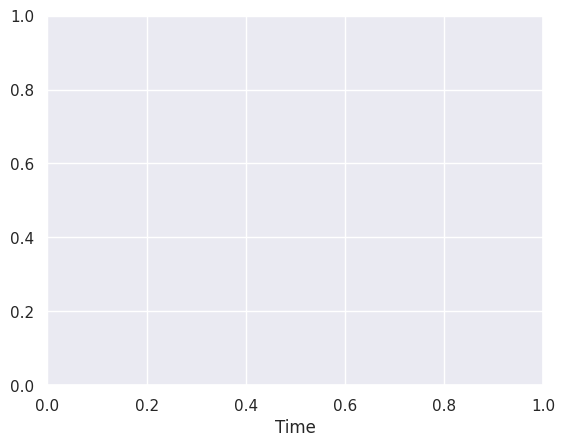

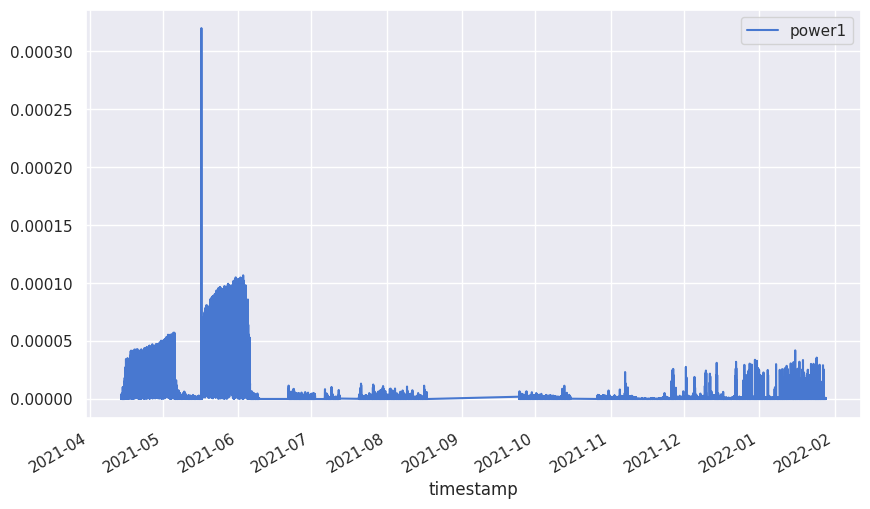

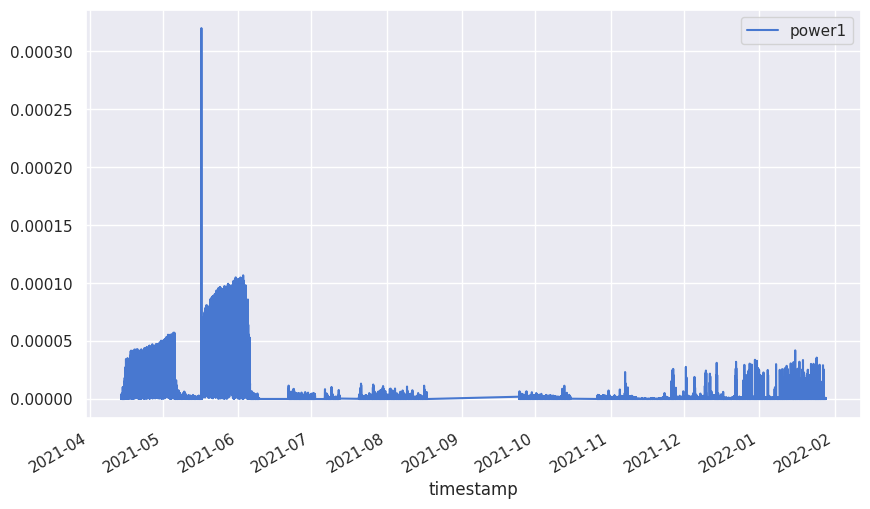

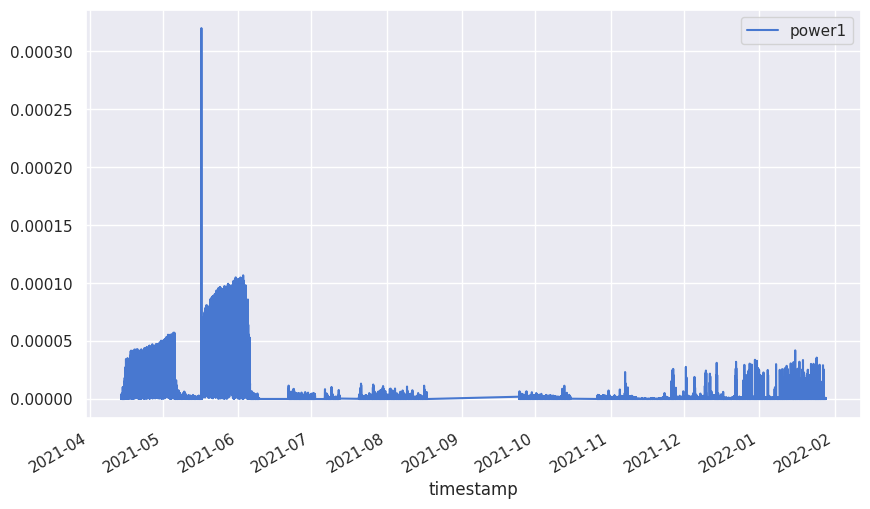

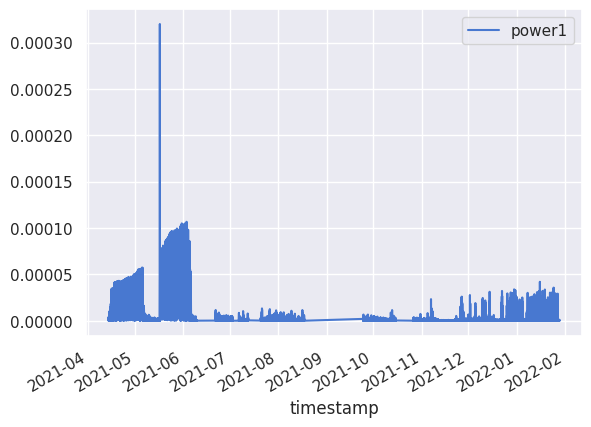

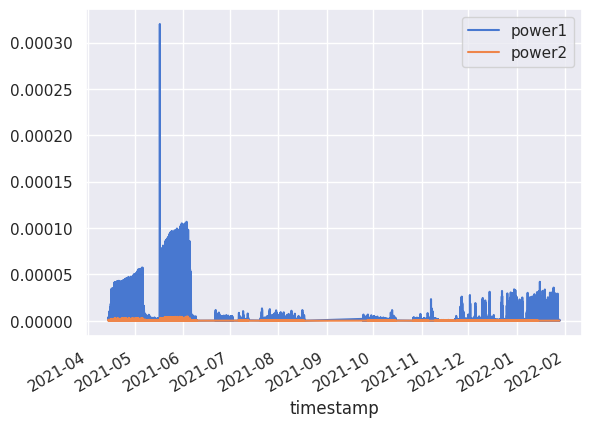

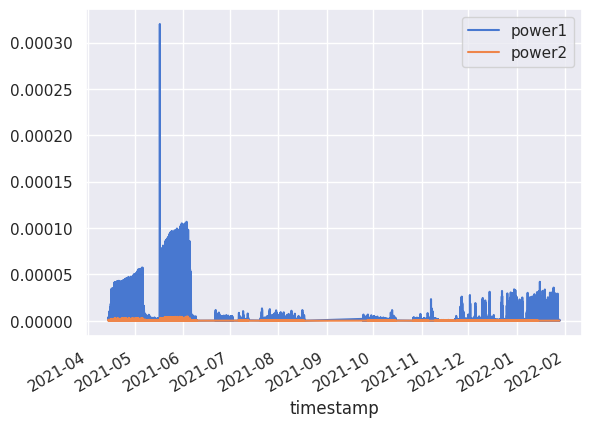

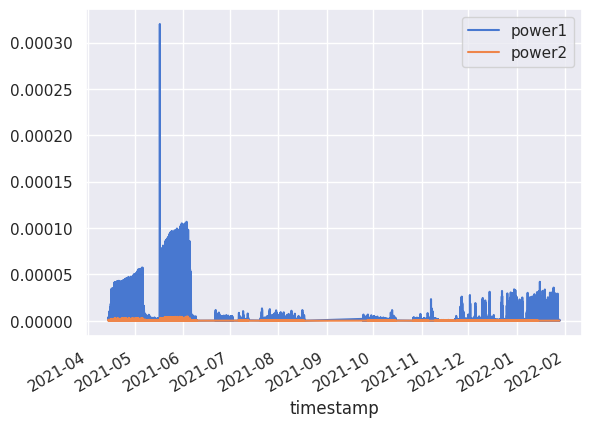

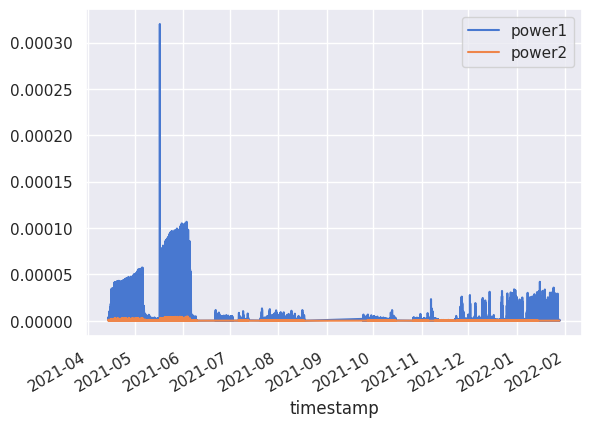

In [ ]:
df.plot.line(x = 'timestamp', y = ['power1', 'power2'])
plt.show()

In [ ]:
#Re-split data for training
X = df.iloc[:, 0:5]
y = df.iloc[:, 13:15]

#Convert datetime to timestamo for training
X["timestamp"] = X["timestamp"].values.astype("float64")

#Creating training and testing sets
X_train, X_test = train_test_split(X, test_size=0.3, shuffle=False)
y_train, y_test = train_test_split(y, test_size=0.3, shuffle=False)

In [ ]:
#Train model
model = RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=42)
%time model.fit(X_train, y_train)

In [ ]:
#Define SMAPE
def SMAPE(actual, predicted):
    return 1/len(actual) * np.sum(2 * np.abs(predicted-actual) / (np.abs(actual) + np.abs(predicted))*100)

In [ ]:
#Evaluate SMAPE
print("Train SMAPE:\n", SMAPE(y_train, model.predict(X_train)))
print("Test SMAPE:\n", SMAPE(y_test, model.predict(X_test)))


In [ ]:
X_train

,timestamp,sensorID,raw_VWC,temp,EC,I1L_valid,I2L_valid,I1H [nA],I1L [10pA],V1 [10nV],V2 [10nV],I2H [nA],I2L [10pA]
0,1.618355e+09,0.0,2808.10,20.1,492.0,1.0,1.0,-224371.0,-17087841.0,-585527.0,-10510423.0,299587.0,17158775.0
1,1.618355e+09,1.0,1840.79,19.0,10.0,1.0,1.0,-218362.0,-16850187.0,-618459.0,-10514952.0,294798.0,16854901.0
2,1.618355e+09,0.0,2806.60,20.1,508.0,1.0,1.0,-221524.0,-16711276.0,-616247.0,-10512381.0,297539.0,16935843.0
3,1.618355e+09,1.0,1839.75,19.0,11.0,1.0,1.0,-207798.0,-15405023.0,-597200.0,-10501365.0,301540.0,17441004.0
4,1.618355e+09,0.0,2805.84,20.1,494.0,1.0,1.0,-219500.0,-16553419.0,-598060.0,-10513605.0,293601.0,16758723.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1852032,1.643357e+09,0.0,2698.24,10.5,221.0,1.0,1.0,-15592.0,5377451.0,-7741.0,-4170338.0,186923.0,6969985.0
1852033,1.643357e+09,0.0,2697.56,10.5,224.0,1.0,1.0,-60884.0,721828.0,-7249.0,-4416113.0,128858.0,1205795.0
1852034,1.643357e+09,0.0,2697.79,10.5,221.0,1.0,1.0,-62560.0,353781.0,-6512.0,-4442184.0,126432.0,688217.0
1852035,1.643357e+09,0.0,2697.84,10.5,220.0,1.0,1.0,-61517.0,484560.0,-7987.0,-4464582.0,123439.0,491466.0
